In [1]:
import numpy as np
from matplotlib import pyplot as plt

# CMP Assignment 7
## Andrew Loeppky

**1.  (2 points)** Calculate the critical germ radius for homogeneous ice nucleation at -23°C, -33°C, and -43°C. Assume a spherical germ.  Make sure that the units are correct

The critical germ radius occurs when the free energy of i-mer formation crosses a maximum. Start with eq 7.19

$$
\Delta F = -\frac{4\pi a_i^3}{3\nu_{mole}}k_bTln(S) + 4\pi a^2 \sigma
$$

differentiate and set the derivative equal to zero (find the function maxima):

$$
\frac{\partial\Delta F}{\partial a} = -\frac{4\pi 3a_i^2}{3\nu_{mole}}k_bTln(S) + 4\pi(2) a \sigma = 0
$$

so the critical germ radius is:

$$
a_g = \frac{2 \sigma_{i,w}\nu_{mole}}{k_bTln(S)}
$$

(note the error in Wang 7.20, off by a factor of pi) Calculate $\nu_{mole}$, the molecular volume of water/ice, obtained by dividing molar mass by $NA$ times macroscopic density

$$
\nu_{mole} = \frac{M_w (kg/mol)}{\rho NA(kg/m^3mol)}
$$

In [2]:
NA = 6.02*10**23 # Avagadros num
kb = kb = 1.3806503 * 10 ** -23  # m2 kg s-2 K-1 boltzmann const
rho_w = 1000 # kg/m3
rho_i = 920 # kg/m3
Mw = 18.02 / 1000 # kg/mol

v_mole_w = Mw / (rho_w*NA)
v_mole_i = Mw / (rho_i*NA)

$\sigma_{i,w}$ and $S$ can be obtained using the following parameterizations over the temperature range relevant to ice nucleation:

$
\sigma_{i,w} = 189.081 + 13.1625T + 0.3469T^2+ (3.12\cdot10^{−3})T^3
$

$
ln(e_{s,i}) = 9.550426−(5723.265T^{−1}) + 3.53068  ln(T)−0.00728332T
$

$
ln(e_{s,w}) = 54.842763−6763.22T^{−1} − 4.21ln(T) + 0.000367T + tanh(0.0415(T−218.8))(53.878−1331.22T^{−1} − 9.44523  ln(T) + 0.014025T)
$

where $S$ is defined as $e_{s,w}/e_{s,i}$

In [3]:
def sig_iw(T):
    """
    calculate surface tension of an ice-water interface given temperature (kelvin)
    """
    T_c = T - 273.15
    sig = (
        189.081 + 13.1625 * T_c + 0.3469 * T_c ** 2 + 3.12 * 10 ** -3 * T_c ** 3
    )  # 10^-3 N/m
    sig *= 10 ** -3  # conversion to SI units N/m
    return sig


def S_iw(T):
    """
    calculates the saturation ratio of an ice-water interface given temperature (kelvin)
    """
    e_si = np.exp(
        9.550426 - 5723.265 * T ** -1 + 3.53068 * np.log(T) - 0.00728332 * T
    )  # Pa
    e_sw = np.exp(
        54.842763
        - 6763.22 * T ** -1
        - 4.21 * np.log(T)
        + 0.000367 * T
        + np.tanh(0.0415 * (T - 218.8))
        * (53.878 - 1331.22 * T ** -1 - 9.44523 * np.log(T) + 0.014025 * T)
    )  # Pa
    return e_sw / e_si


def a_g(T):
    """
    calculates the critical radius of an ice germ given temperature
    """
    a_g = (2 * sig_iw(T) * v_mole_i) / (kb * T * np.log(S_iw(T)))
    return a_g

In [26]:
temps = np.linspace(230,250,20) # np.array([230.,240.,250.])
print(f"temp (oC)|  critical germ rad (nm)")
print("-----------------------------------")
for temp in temps:
    print(
        f"{round(temp-273.15)}      |        {round(a_g(temp)*10**9,2)}"
    )  # print the critical germ rad in nanometers

temp (oC)|  critical germ rad (nm)
-----------------------------------
-43      |        0.81
-42      |        0.85
-41      |        0.9
-40      |        0.94
-39      |        0.98
-38      |        1.02
-37      |        1.06
-36      |        1.1
-35      |        1.15
-34      |        1.2
-33      |        1.27
-32      |        1.34
-31      |        1.42
-29      |        1.52
-28      |        1.64
-27      |        1.78
-26      |        1.94
-25      |        2.13
-24      |        2.36
-23      |        2.63


**2.  (4 points)** Plot the number of spherical ice embryos with radii $0.5 nm< r_i<5 nm$ found in a cloud droplet at equilibrium with the radius of 10μm.  Use temperatures of -23°C,-33°C, and -43°C. Use a logarithmic y-axis.  Include in your plot a vertical line for the critical germ radius from part (1).  (Hint:  Plot the number of ice embryos vs the size of the embryos).

Starting with equation 7.1 (Wang), we can modify for a spherical ice germ nucleating in liquid water:

$$
N_i = N_{sat,i}exp\left(\frac{-\Delta F_i}{k_bT}\right)
$$

Where $N_i$ is the number of embryos in state $i$, $N_{sat,i}$ is the total number of molecules in the system, and $\Delta F_i$ is the free energy of formation for each i-mer, given by eq 7.19

$$
\Delta F_i = -\frac{4}{3}\frac{\pi a^3}{\nu_{molecular}}k_b T ln(S) + 4\pi a_i^2\sigma
$$

Find the number of molecules in a (spherical) 10μm liquid droplet:

$$
N_{sat,i} = \frac{4\pi a_{drop}^3}{3\nu_{mole,w}}
$$

Or, if one wishes to calculate the number of molecules in a given volume of water:

$$
N_{sat,i} = \frac{\nu_{drop}}{\nu_{mole}}
$$

In [27]:
def delF(T, a):
    """
    calculates the free energy of spherical ice i-mer formation for temp T and i-mer radius a
    """
    F = (-(4 / 3) * np.pi * a ** 3 * kb * T * np.log(S_iw(T)) / v_mole_i) + (
        4 * np.pi * a ** 2 * sig_iw(T)  # wang eq 7.20
    )
    return F


def Ni(T, a, N_sati):  # /m3
    """
    calculates the number of ice i-mers of desired radius 'a', given temp T
    """
    Ni = N_sati * np.exp(-delF(T, a) / (kb * T))  # wang eq 7.1
    return Ni

In [38]:
## DEFINE DROPLET SIZE HERE:
droprad = 10 * 10 ** -6  # m
N_sati = (4 * np.pi * droprad ** 3) / (3 * v_mole_w)  # number of molecules in 10um droplet

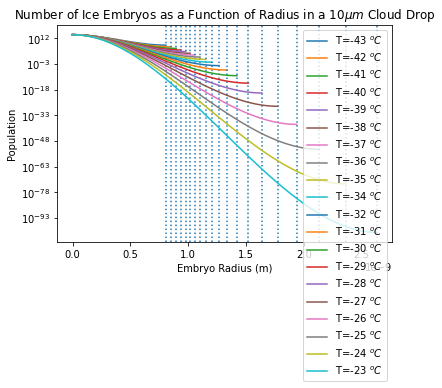

In [39]:
# find the number of embryos occurring /m3 of supercooled water
#N_sati = 1/v_mole_w
'''
colors = ["b", "g", "r"]
for i in range(len(temps)):
    a = np.linspace(0, a_g(temps[i]), 100)# only plot out to critical radius

    the_temp = round(temps[i])
    plt.plot(a, Ni(temps[i], a, N_sati), label=f"T={the_temp-273} $^oC$", color=colors[i])

    plt.axvline(
        x=a_g(temps[i]), color=colors[i], ls=":"
    )  # draw the critical radius at T
'''    
for i in range(len(temps)):
    a = np.linspace(0, a_g(temps[i]), 100)# only plot out to critical radius

    the_temp = round(temps[i])
    plt.plot(a, Ni(temps[i], a, N_sati), label=f"T={the_temp-273} $^oC$")

    plt.axvline(
        x=a_g(temps[i]), ls=":"
    )  # draw the critical radius at T

plt.legend()
plt.yscale("log")
#plt.ylim([10 ** -102, 10 ** 15])
plt.title("Number of Ice Embryos as a Function of Radius in a 10$\mu m$ Cloud Drop")
plt.xlabel("Embryo Radius (m)")
plt.ylabel("Population");

For temperatures above ~$-40^oC$, we see that the number of critical embryos is less than one for a 10$\mu m$ cloud droplet, so the chances of droplet activation are nearly zero

**3.  (2 points)** We can now formulate a nucleation rate that determines how many critical ice germs are activated per second.  This nucleation rate is given by $J=K∗N_{i,crit}$ with the coefficient $K = 0.3 s^{−1}$.  (you can obtain $N_{i,crit}$ from Q2)

Now we look at more than only one droplet.  We want to know how fast these droplets (r= 10μm) freeze.  We assume that a droplet freezes once an ice germ is activated inside the droplet.  With this assumption, we can derive the equation:

$$
N_u=N_0e^{−V_dJt}
$$

where $N_u$ is the number of unfrozen droplets,$N_0$ is the initial number of all droplets,$V_d$ is the volume of a droplet, $J$ is the nucleation rate, and $t$ is the time. Calculate the respective freezing times at which 50% of the droplets will freeze for the 3 temperatures from above.

To solve for the time 50% of droplets freeze, set $N_u/N_0 = 1/2$ and invert the equation for $t$

$$
t=\frac{-ln\left(\frac{1}{2}\right)}{V_dJ}
$$

First, calculate $N_{i,crit}$, the number of critical i-mers in the droplet given temperature $T$, and resulting $J$:

In [30]:
# these will only work for a droplet size defined above, please excuse messy global variable use
def N_icrit(T):
    """
    calculate the instantaneous number of embryos at critical radius 
    """
    N_icrit = Ni(T, a_g(T), N_sati)
    return N_icrit

def J(T):
    J = 0.3 * N_icrit(T)
    return J

def t_50(T):
    t_50 = -np.log(0.5) / J(T)
    return t_50

temp (oC)    |         t_50 (s) 
-----------------------------------------


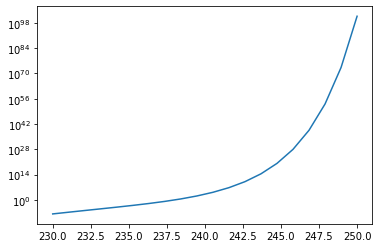

In [35]:
print("temp (oC)    |         t_50 (s) ")
print("-----------------------------------------")
t = []
for temp in temps:
    t.append(t_50(temp))
    # print(f"   {round(temp-273)}       |  {(t)} ")

plt.plot(temps,t)
plt.yscale('log')

So at -23$^o$C the freezing time is orders of magnitude longer than the age of the universe. At lower temperatures -33$^o$C and -43$^o$C, the probability of homogeneous nucleation increases dramatically.

**4.  (1 point)** Explain from the results of questions 2 and 3, why the threshold for homogeneous freezing is so low at -43°C

The surface/interfacial tension of water is comparatively very high, meaning there is a large energetic cost to creating an ice/water interface. For supercooled droplets that "want" to transition into the solid (ie lower energy) state, the benefit of existing as bulk ice must outweigh the cost of constructing the interface, which only occurs around -40

**5.  (3 points)** Now we want to calculate immersion freezing of droplets by dust particles.  The theoretical description of heterogeneous freezing processes on aerosol particles is still not completely understood.  One theory, the ice-active surface sites theory, assumes that the time dependence of the ice nucleation process can be neglected under specific conditions.Ice nucleation thus depends on temperature (for immersion freezing) or $RH_{ice}$ (for deposition nucleation).  The ice nucleation ability of an aerosol species can then be expressed by $n_s$, the number of ice active surface sites per unit surface area of the material, which can be approximated as:

$$
n_s = \frac{N_{ice}}{SA}
$$

with $N_{ice}$ being the total number concentration of ice crystals and $SA$ the total surface area of the aerosol particles per unit volume of air.  (The equation assumes 1 active site per particle.)  For natural dusts can be approximated as (Niemand et al., 2012):

$$
n_s(T) = e^{-0.517(T-273.15)+8.934}m^{-2}
$$ 

valid for $-36^oC < T < -12^oC$. Now let’s assume a cloud with 100 cm−3 droplets that formed in an air parcel with dust concentrations of 200 L−1 with radius of 0.2μm (which can be assumed to be spherical).How many ice crystals are formed by immersion freezing at -23°C, -33°C, and -43°C? What is the problem with your answer at the coldest temperature?

total surface area of the dust INPs is the number concentration/volume of air times the surface area per dust mote of radius $a$

$$
SA = 4\pi a^2 \cdot [dust]
$$

Combine the equations above and solve for $N_{ice}$:

$$
N_{ice} = e^{-0.517(T-273.15)+8.934}\cdot 4\pi a^2 \cdot [dust]
$$

Assuming all dust is incorporated into droplets and freezes in the immersion mode, we can solve for $N_{ice}$ as a function of temperature

In [ ]:
dust = 200  # /L
dust *= 1000  # L/m3
a = 0.2 * 10 ** -6  # m


def N_ice(T):
    N_ice = np.exp(-0.517 * (T - 273.15) + 8.934) * 4 * np.pi * a **2 * dust
    return N_ice

print('temp (oC)    |  N_ice  ')
print('-------------------------')
for temp in temps:
    N = N_ice(temp)
    print(f'   {round(temp-273)}       |  {(round(N))} ')

Because of heterogeneous freezing, we see an exponential increase (much less steep than homogeneous freezing) in ice particles with decreasing temperature. At temperatures close to -40$^oC$, homogeneous freezing can also occur, the effect of which will be difficult to separate from that of heterogeneous freezing.

**6. (1 point)** How do your results from (5) fit into the picture of (3) and (4)?  (Discuss the role of homogeneous and heterogeneous nucleation for ice formation at different temperatures.

We have shown that homogeneous freezing of water droplets in atmospheric conditions is virtually impossible above ~ -40$^oC$. However, ice most certainly occurs in clouds above this temperature. Ice nuclei like the dust in question 5 are thought to lower the energy barrier preventing nucleation of ice, and thus facilitate freezing at warmer temperatures. Exactly how this occurs is still extremely unclear.